# EuroSat dataset - Binary Classification with Regularization, Dropout, and Batch Normalization

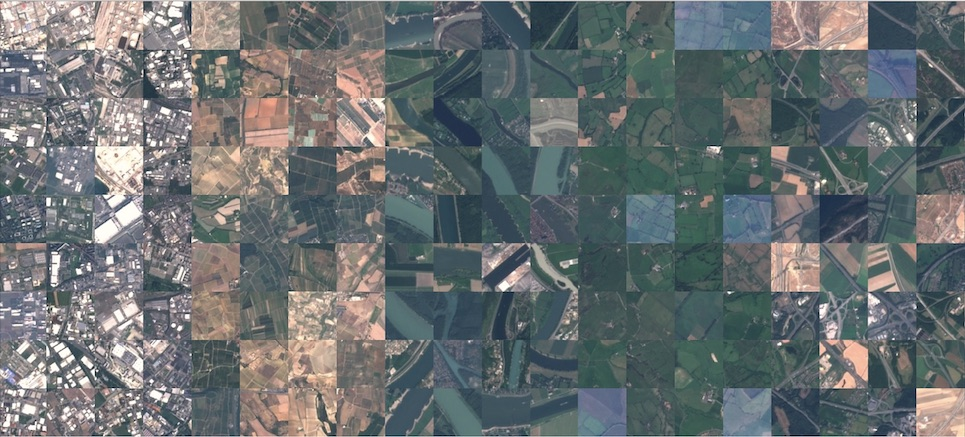

#### The EuroSAT dataset

In this assignment, you will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

Your goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some of the saving and loading techniques you have learned in the previous sessions.

In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt


2025-11-29 00:07:43.077374: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 00:07:43.091212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764396463.104245    8183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764396463.109425    8183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764396463.121201    8183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load the Data

In [251]:
def load_eurosat_data(
    data_root="weekly_data/EuroSAT_RGB/EuroSAT_RGB",
    image_size=(64, 64),
    batch_size=32,
    fraction=0.05,      # 0.05 = use 5% of images; set to 1.0 for all
    seed=1337,
):
    """
    Returns (x_train, y_train), (x_test, y_test) as NumPy arrays
    built from the EuroSAT RGB directory structure.
    """

    data_root = Path(data_root)

    # 1) Build TF datasets from directory (80% train, 20% "test")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
        label_mode="int",
        
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_root,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
        label_mode="int",
    )

    # 2) Optionally reduce to a fraction (e.g. 5%) of the images
    if fraction is not None and fraction < 1.0:
        # Estimate total number of examples from number of batches * batch_size
        n_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
        n_test_batches  = tf.data.experimental.cardinality(test_ds).numpy()

        n_train = n_train_batches * batch_size
        n_test  = n_test_batches * batch_size

        n_train_small = int(n_train * fraction)
        n_test_small  = int(n_test * fraction)

        train_ds = train_ds.unbatch().take(n_train_small).batch(batch_size)
        test_ds  = test_ds.unbatch().take(n_test_small).batch(batch_size)

    # 3) Convert tf.data.Dataset → NumPy arrays
    def ds_to_numpy(ds):
        xs, ys = [], []
        for x_batch, y_batch in ds:
            xs.append(x_batch.numpy())
            ys.append(y_batch.numpy())
        x = np.concatenate(xs, axis=0)
        y = np.concatenate(ys, axis=0)
        return x, y

    x_train, y_train = ds_to_numpy(train_ds)
    x_test, y_test   = ds_to_numpy(test_ds)

    return (x_train, y_train), (x_test, y_test)


In [252]:
(x_train, y_train), (x_test, y_test) = load_eurosat_data(fraction=1.0)

# scale pixels to [0, 1]
x_train = x_train / 255.0
x_test  = x_test  / 255.0

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
(21600, 64, 64, 3) (21600,)
(5400, 64, 64, 3) (5400,)


In [84]:
def get_class_names(data_root="weekly_data/EuroSAT_RGB/EuroSAT_RGB"):
    """Return the list of class names in the dataset."""
    data_root = Path(data_root)

    tmp_ds = tf.keras.utils.image_dataset_from_directory(
        data_root,
        image_size=(64, 64),
        batch_size=32,
        shuffle=False,        # order doesn't matter here
        label_mode="int",
    )

    print(tmp_ds.class_names)
    return tmp_ds.class_names

In [253]:
class_names = get_class_names()

Found 27000 files belonging to 10 classes.
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [254]:
def decode_label(idx):
    """Convert numeric label to string label."""
    global class_names
    idx = int(idx)
    return class_names[idx]

def print_label_mappings(y_test):
    """Print all numeric to string label mappings."""
    unique_labels = sorted(set(y_test))
    for i in unique_labels:
        print(i, "→", decode_label(i))

In [255]:
print_label_mappings(y_test)

0 → AnnualCrop
1 → Forest
2 → HerbaceousVegetation
3 → Highway
4 → Industrial
5 → Pasture
6 → PermanentCrop
7 → Residential
8 → River
9 → SeaLake


In [256]:
def plot_one_image(x_test, y_test, idx=None, decode_label=decode_label):
    """Plot one random image from the test set with its label."""
    if idx is None:
        idx = np.random.randint(0, x_test.shape[0])
    img = x_test[idx]          # shape (64, 64, 3)
    label = y_test[idx]

    print("Label:", label)
    plt.imshow(img)
    plt.axis("off")
    plt.title(decode_label(label))
    plt.show()

Label: 0


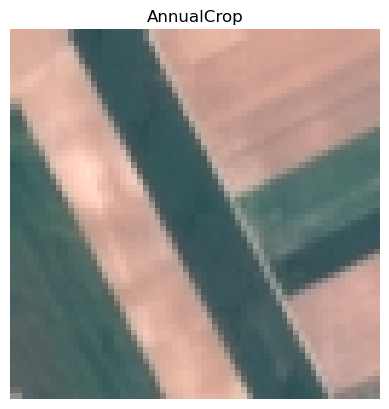

In [257]:
plot_one_image(x_test, y_test)

In [258]:
def plot_all_classes(x_test, y_test, decode_label=decode_label):
    """Plot one image from each class in the test set."""
    unique_labels = sorted(set(y_test))
    plt.figure(figsize=(15, 6))
    for i, unique_label in enumerate(unique_labels):
        plt.subplot(2, 5, i + 1)
        plt.axis("off")
        # make it random by changing [0][0] to np.random.randint(...)
        idx = np.where(y_test == unique_label)[0][np.random.randint(0, len(np.where(y_test == unique_label)[0]))]
        img = x_test[idx]
        plt.imshow(img)
        plt.title(decode_label(unique_label))
    plt.show()

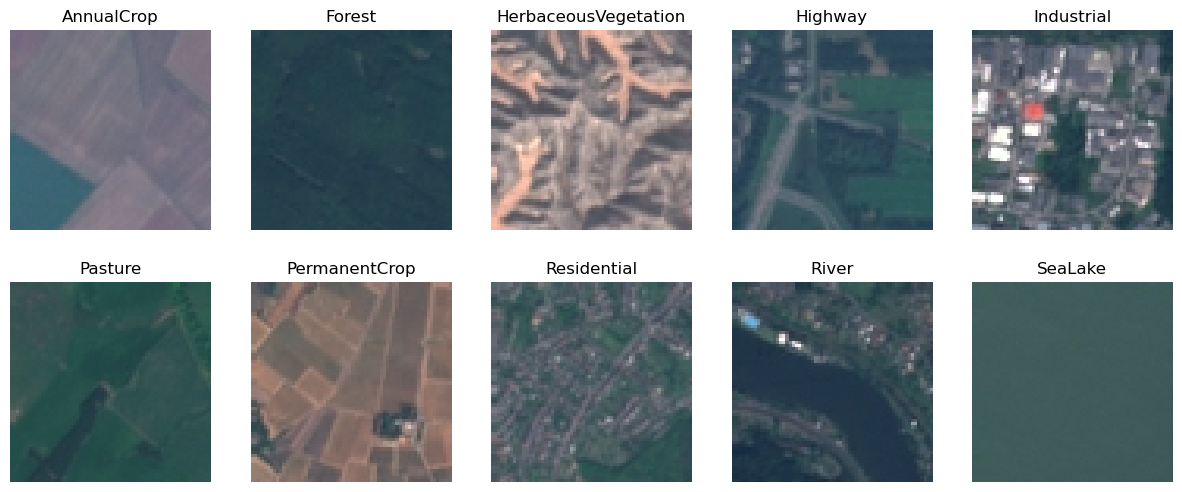

In [259]:
plot_all_classes(x_test, y_test)

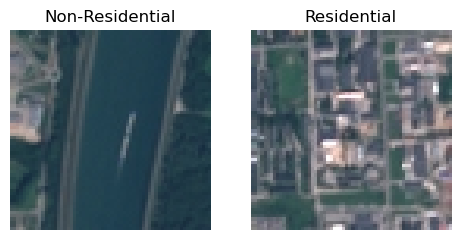

(21600, 64, 64, 3) (21600,)
(5400, 64, 64, 3) (5400,)
Unique binary labels in y_test_binary: 2
Unique binary labels in y_train_binary: 2


In [260]:
def translate_to_binary(y_train, y_test):
    """Translate the multi-class labels to binary labels."""
    # change the y_test to binary. Residential (or industrial) vs Non-Residential 
    y_test_binary = np.array([1 if decode_label(y) == "Residential" or decode_label(y) == "Industrial" else 0 for y in y_test])
    y_train_binary = np.array([1 if decode_label(y) == "Residential" or decode_label(y) == "Industrial" else 0 for y in y_train])
    return y_train_binary, y_test_binary

def decode_label_binary(idx):
    """Convert numeric label to string label for binary classification."""
    return "Residential" if idx == 1 else "Non-Residential"

y_train_binary, y_test_binary = translate_to_binary(y_train, y_test)
plot_all_classes(x_test, y_test_binary, decode_label=decode_label_binary)
print(x_train.shape, y_train_binary.shape)
print(x_test.shape, y_test_binary.shape)
print("Unique binary labels in y_test_binary:", len(set(y_test_binary)))
print("Unique binary labels in y_train_binary:", len(set(y_train_binary)))

In [ ]:
# class imbalance check
unique, counts = np.unique(y_train_binary, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in y_train_binary:", class_distribution)
print("Class distribution in y_train_binary:", {k: v / len(y_train_binary) for k, v in class_distribution.items()})

unique, counts = np.unique(y_test_binary, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in y_test_binary:", class_distribution)
print("Class distribution in y_test_binary:", {k: v / len(y_test_binary) for k, v in class_distribution.items()})

Class distribution in y_train_binary: {np.int64(0): np.int64(17199), np.int64(1): np.int64(4401)}
Class distribution in y_train_binary: {np.int64(0): np.float64(0.79625), np.int64(1): np.float64(0.20375)}
Class distribution in y_test_binary: {np.int64(0): np.float64(3.185), np.int64(1): np.float64(0.815)}


# Class imbalance handling

In [224]:
def weighted_BCE(y_train_binary):
    """
    Compute class weights to handle imbalance in the training data.
    """
    # compute class weights to handle imbalance
    from sklearn.utils import class_weight
    class_weight_values = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_binary),
        y=y_train_binary
    )
    class_weight_dict = dict(enumerate(class_weight_values))
    print("Class weight dict:", class_weight_dict)

    return class_weight_dict

class_weight_dict = weighted_BCE(y_train_binary) 

print("Manual weights")
N = len(y_train_binary)
N1 = len([y for y in y_train_binary if y == 1])
w1 = N / (2 * N1)
print("Manual weight for class 1:", w1)

Class weight dict: {0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}
Manual weights
Manual weight for class 1: 2.4539877300613497


In [211]:
import tensorflow as tf
from tensorflow.keras import backend as K

def make_focal_loss(alpha=0.25, gamma=2.0):
    """
    Factory that returns a binary focal-loss function for sigmoid outputs.
    alpha: weight for positive class.
    gamma: focusing parameter >= 0.
    """
    alpha = float(alpha)
    gamma = float(gamma)

    def focal_loss(y_true, y_pred):
        # y_true: shape (batch, 1) or (batch,)
        # y_pred: sigmoid outputs in (0, 1).
        y_true_f = tf.cast(y_true, tf.float32)

        # Avoid log(0)
        epsilon = K.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # p_t = p if y=1 else (1-p)
        p_t = y_true_f * y_pred_clipped + (1.0 - y_true_f) * (1.0 - y_pred_clipped)

        # alpha_t = alpha if y=1 else (1-alpha)
        alpha_t = y_true_f * alpha + (1.0 - y_true_f) * (1.0 - alpha)

        # Focal loss
        loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)

        # Mean over batch
        return tf.reduce_mean(loss)

    return focal_loss


# Build the neural network model

In [11]:
def get_resnet50_model(input_shape):
    # import resnet50 model
    from tensorflow.keras.applications import ResNet50

    resnet_model = ResNet50(
        weights="imagenet",      # load weights pre-trained on ImageNet
        include_top=False,       # do not include the ImageNet classifier at the top
        input_shape=(64, 64, 3) # specify input shape
    )

    from tensorflow.keras.layers import GlobalAveragePooling2D

    # modify the model to add a classifier on top
    model = Sequential()
    model.add(resnet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))

    # train to classify Residential vs Non-Residential
    optimizer = tf.keras.optimizers.Adam()
    loss = 'binary_crossentropy'
    metrics = ['accuracy']

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    return model

In [215]:
from tensorflow.keras import layers, regularizers, metrics, optimizers

def get_new_model(input_shape, loss_fn="binary_crossentropy"):
    """
    Build and compile a binary CNN, with pluggable loss (BCE or focal).
    loss_fn can be a string ('binary_crossentropy') or a callable (e.g. focal_loss).
    """
    model = tf.keras.Sequential()

    regularizer = regularizers.l1_l2(l1=0.005, l2=0.001)

    # Conv 1
    model.add(layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
        name="conv_1",
        kernel_regularizer=regularizer,
    ))

    # Conv 2
    model.add(layers.Conv2D(
        filters=8,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name="conv_2",
        kernel_regularizer=regularizer,
    ))

    # MaxPool
    model.add(layers.MaxPooling2D(pool_size=(8, 8), name="pool_1"))

    # Flatten
    model.add(layers.Flatten(name="flatten"))

    # Dense block 1
    model.add(layers.Dense(32, activation="relu",
                           name="dense_1", kernel_regularizer=regularizer))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Dense block 2
    model.add(layers.Dense(32, activation="relu",
                           name="dense_1_dropout", kernel_regularizer=regularizer))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output: 1 unit, sigmoid
    model.add(layers.Dense(1, activation="sigmoid",
                           name="dense_2", kernel_regularizer=regularizer))

    optimizer = optimizers.Adam()

    metrics_list = [
        metrics.BinaryAccuracy(name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        metrics.AUC(name="auc_roc", curve="ROC"),
        metrics.AUC(name="auc_pr", curve="PR"),
    ]
    names_metrics = [m.name for m in metrics_list]

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics_list,
    )

    return model, names_metrics


#### Compile and evaluate the model

In [240]:
focal_loss = make_focal_loss(alpha=0.25, gamma=2.0)
model, names_metrics = get_new_model(input_shape=x_train.shape[1:],loss_fn='binary_crossentropy')
model.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_dropout (Dense)         │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,369 (75.66 KB)

 Trainable params: 19,241 (75.16 KB)

 Non-trainable params: 128 (512.00 B)

In [241]:

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    results = model.evaluate(x=x_test, y=y_test)
    for metric_name, metric_value in zip(names_metrics, results):
        print(f'{metric_name}: {metric_value:0.3f}')
    

In [242]:
get_test_accuracy(model, x_test, y_test_binary)

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7965 - auc_pr: 0.1262 - auc_roc: 0.2154 - loss: 6.4965 - precision: 0.0000e+00 - recall: 0.0000e+00
accuracy: 6.496
precision: 0.796
recall: 0.000
auc_roc: 0.000
auc_pr: 0.215


# Create checkpoints to save model during training, with a criterion

In [243]:

import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_best_only(PATH = "resnet_checkpoints_best_only"):
    os.makedirs(PATH, exist_ok=True)
    filepath = os.path.join(PATH, "checkpoint.keras")

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=False,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=0,
    )
    return checkpoint




def get_checkpoint_best(metric="recall", PATH="binary_checkpoints_best_precision"):
    """
    Save the model with highest validation precision.
    """
    os.makedirs(PATH, exist_ok=True)
    filepath = os.path.join(PATH, "checkpoint.keras")

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=False,
        save_best_only=True,
        monitor=f"val_{metric}",  # <-- key line
        verbose=1,
    )
    return checkpoint




def get_early_stopping_precision(patience=3):
    """
    Stop training when validation precision has not improved.
    """
    early_stopping = EarlyStopping(
        monitor="loss",  # <-- key line
        mode="max",
        patience=patience,
        min_delta=0.0001,            # you can keep 0.001 if you want
        restore_best_weights=True # useful so you end with best-precision weights
    )
    return early_stopping


# Train model using the callbacks

In [244]:
patience = 10


checkpoint_best_recall = get_checkpoint_best(metric="recall", PATH="binary_checkpoints_best_recall")
early_stopping_precision = get_early_stopping_precision(patience=patience)

callbacks = [checkpoint_best_recall, early_stopping_precision]


history = model.fit(
    x_train, y_train_binary,
    epochs=50,
    validation_data=(x_test, y_test_binary),  # here it's acting as val
    callbacks=callbacks,
    class_weight=class_weight_dict,   # strongly recommended with imbalance
)


Epoch 1/50
673/675 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7260 - auc_pr: 0.6345 - auc_roc: 0.8252 - loss: 3.1973 - precision: 0.4364 - recall: 0.7960
Epoch 1: val_recall improved from None to 0.55596, saving model to binary_checkpoints_best_recall/checkpoint.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8447 - auc_pr: 0.8019 - auc_roc: 0.9357 - loss: 1.9480 - precision: 0.5774 - recall: 0.8875 - val_accuracy: 0.9083 - val_auc_pr: 0.9672 - val_auc_roc: 0.9920 - val_loss: 0.8244 - val_precision: 0.9887 - val_recall: 0.5560
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9329 - auc_pr: 0.9038 - auc_roc: 0.9788 - loss: 0.7050 - precision: 0.7784 - recall: 0.9456
Epoch 2: val_recall did not improve from 0.55596
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9423 - auc_pr: 0.9232 - auc_roc: 0.9834 - loss: 0.5777 - precision: 0.8019 - recall: 0.9521 - val_accuracy: 0.8413 - val_auc_pr: 0.9728 - val_auc_roc: 0.9914 - val_loss: 0.6445 - val_pre

In [245]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Predicted probabilities
y_val_proba = model.predict(x_test).ravel()  # here x_test is your "val"

precisions, recalls, thresholds = precision_recall_curve(y_test_binary, y_val_proba)

# Example 1: choose threshold that maximizes F1
f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_tau = thresholds[best_idx]

print("Best tau:", best_tau)
print("Precision at best tau:", precisions[best_idx])
print("Recall at best tau:", recalls[best_idx])
print("F1 at best tau:", f1_scores[best_idx])

# Example 2: if you want *at least* some precision level, say >= 0.9:
target_precision = 0.9
valid_idxs = np.where(precisions[:-1] >= target_precision)[0]
if len(valid_idxs) > 0:
    idx = valid_idxs[0]  # first threshold achieving that precision
    tau_90 = thresholds[idx]
    print("Tau for >=90% precision:", tau_90, " recall:", recalls[idx])


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Best tau: 0.10620373
Precision at best tau: 0.8556280587275693
Recall at best tau: 0.9545040946314831
F1 at best tau: 0.9023655864127682
Tau for >=90% precision: 0.15229747  recall: 0.8926296633303002


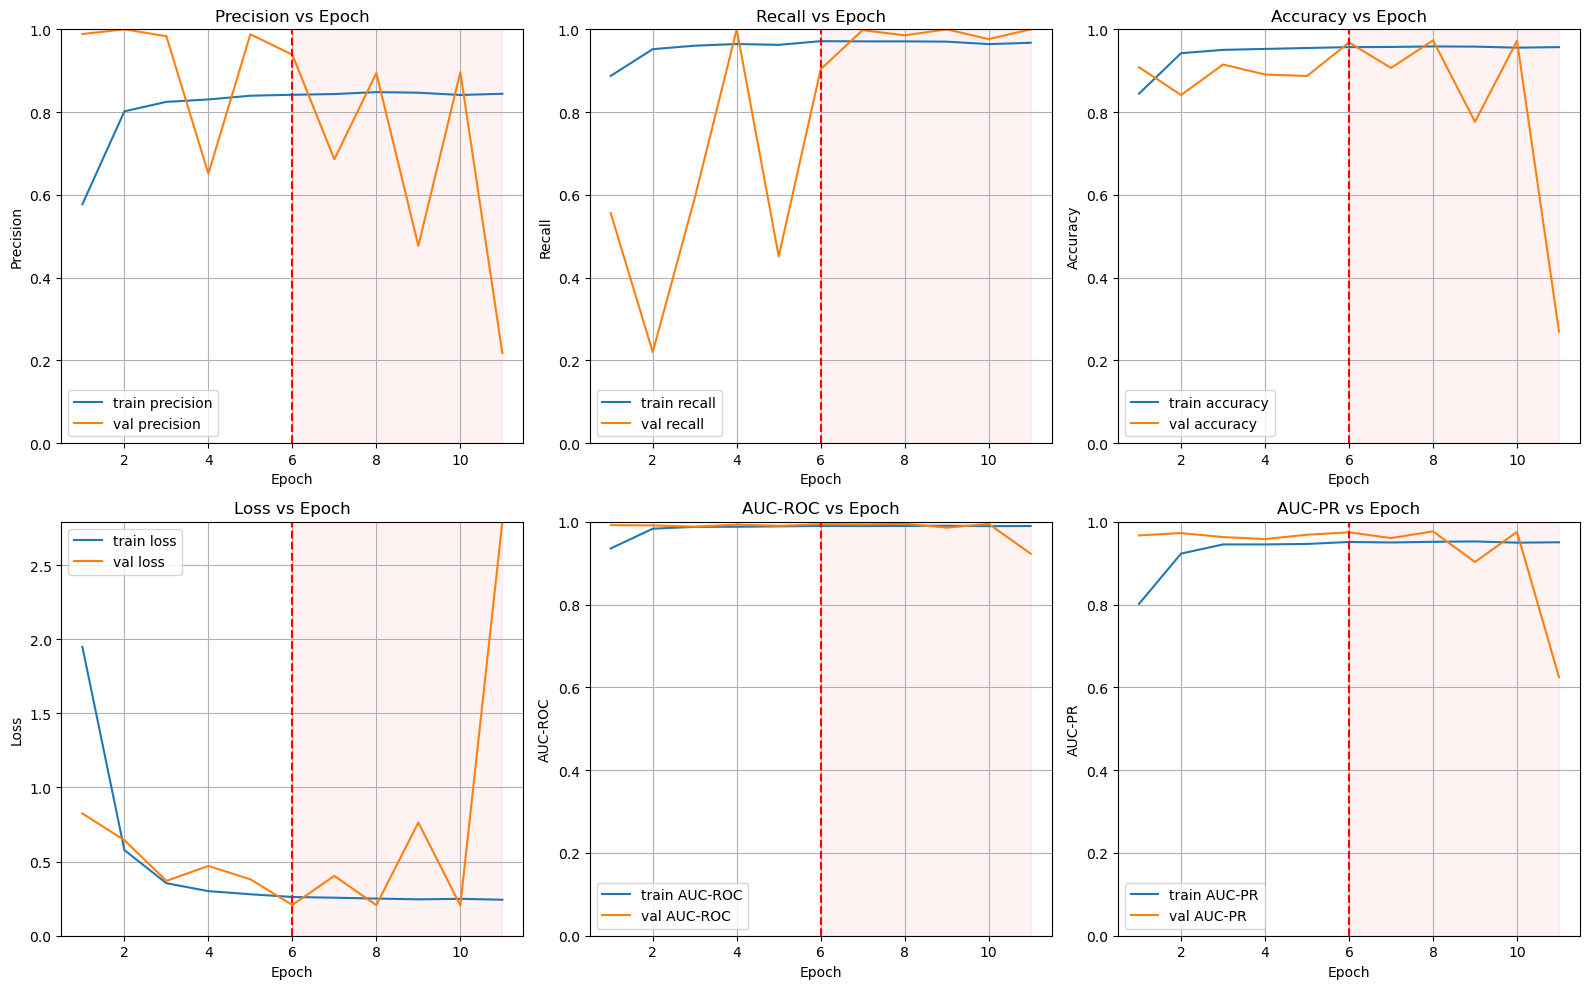

In [246]:
import numpy as np
import matplotlib.pyplot as plt




def plot_history_precision_recall(history, patience=5):
    """
    Plot training/validation precision, recall and accuracy vs epoch.
    Requires you to have compiled the model with metrics:
      'precision', 'recall', 'accuracy'
    """
    hist = history.history
    epochs = np.arange(1, len(hist["loss"]) + 1)

    x_fill_min = len(history.history['loss']) - patience
    x_fill_max = len(history.history['loss'])

    plt.figure(figsize=(16, 10))

    # Precision
    # in 1x1 from 2x3
    plt.subplot(2, 3, 1)
    if "precision" in hist and "val_precision" in hist:
        plt.plot(epochs, hist["precision"], label="train precision")
        plt.plot(epochs, hist["val_precision"], label="val precision")
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.title("Precision vs Epoch")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(y=[0,1], x1=x_fill_min, x2=x_fill_max, color='red', alpha=0.05)

    else:
        plt.text(0.5, 0.5, "precision not in history", ha="center")

    # Recall
    # in 1,2 from 2x3
    plt.subplot(2, 3, 2)
    if "recall" in hist and "val_recall" in hist:
        plt.plot(epochs, hist["recall"], label="train recall")
        plt.plot(epochs, hist["val_recall"], label="val recall")
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.title("Recall vs Epoch")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(y=[0,1], x1=x_fill_min, x2=x_fill_max, color='red', alpha=0.05)
    else:
        plt.text(0.5, 0.5, "recall not in history", ha="center")

    # Accuracy
    plt.subplot(2, 3, 3)
    if "accuracy" in hist and "val_accuracy" in hist:
        plt.plot(epochs, hist["accuracy"], label="train accuracy")
        plt.plot(epochs, hist["val_accuracy"], label="val accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epoch")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(y=[0,1], x1=x_fill_min, x2=x_fill_max, color='red', alpha=0.05)
    else:
        plt.text(0.5, 0.5, "accuracy not in history", ha="center")

    # loss
    plt.subplot(2, 3, 4)
    if "loss" in hist and "val_loss" in hist:
        plt.plot(epochs, hist["loss"], label="train loss")
        plt.plot(epochs, hist["val_loss"], label="val loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.ylim(0, max(max(hist["loss"]), max(hist["val_loss"])))
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(
        y=[0, 
        max(max(history.history['loss']), max(history.history['val_loss']))],
        x1=len(history.history['loss'])-patience,
        x2=len(history.history['loss']),
        color='red',
        alpha=0.05
        )
    else:
        plt.text(0.5, 0.5, "loss not in history", ha="center")

    # ROC and PR curves can be added here if needed
    plt.subplot(2, 3, 5)
    if 'auc_roc' in hist:
        plt.plot(epochs, hist['auc_roc'], label='train AUC-ROC')
        plt.plot(epochs, hist['val_auc_roc'], label='val AUC-ROC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC-ROC')
        plt.title('AUC-ROC vs Epoch')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(y=[0,1], x1=x_fill_min, x2=x_fill_max, color='red', alpha=0.05)
    else:
        plt.text(0.5, 0.5, "AUC-ROC not in history", ha="center")

    plt.subplot(2, 3, 6)
    if 'auc_pr' in hist:
        plt.plot(epochs, hist['auc_pr'], label='train AUC-PR')
        plt.plot(epochs, hist['val_auc_pr'], label='val AUC-PR')
        plt.xlabel('Epoch')
        plt.ylabel('AUC-PR')
        plt.title('AUC-PR vs Epoch')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()

        plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
        plt.fill_betweenx(y=[0,1], x1=x_fill_min, x2=x_fill_max, color='red', alpha=0.05)
    else:
        plt.text(0.5, 0.5, "AUC-PR not in history", ha="center")

    plt.tight_layout()
    plt.show()

plot_history_precision_recall(history)


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


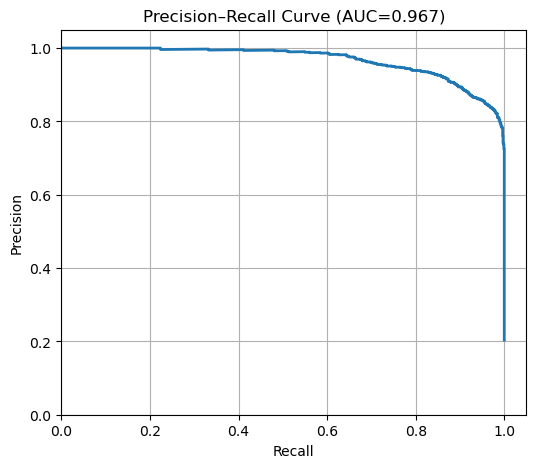

Precision: [0.20351852 0.20355621 0.20359392 ... 1.         1.         1.        ]
Recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.81983621e-03
 9.09918107e-04 0.00000000e+00]
Thresholds: [9.9367055e-04 1.2199623e-03 1.2609913e-03 ... 9.9151856e-01 9.9219596e-01
 9.9714273e-01]


In [247]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(model, x_val, y_val):
    """
    Plot precision-recall curve for the model on (x_val, y_val).
    y_val must be binary {0,1}.
    """
    # Predicted probabilities for positive class
    y_pred_proba = model.predict(x_val).ravel()

    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AUC={pr_auc:.3f})")
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.05)
    plt.show()

    return precision, recall, thresholds

precision, recall, thresholds = plot_precision_recall_curve(model, x_test, y_test_binary)
print("Precision:", precision)
print("Recall:", recall)
print("Thresholds:", thresholds)

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


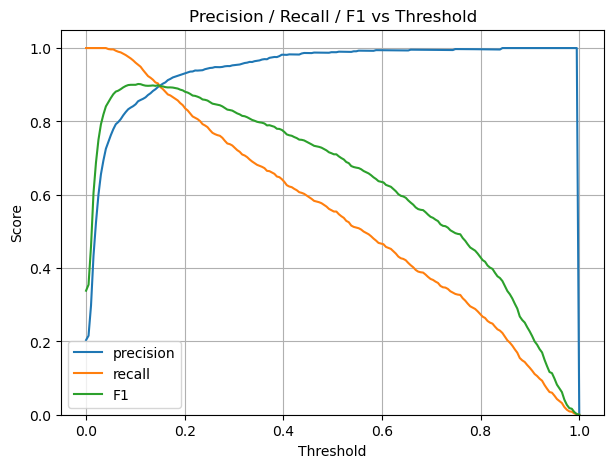

In [248]:
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_threshold_metrics(model, x_val, y_val, num_thresholds=200):
    """
    Plot how precision, recall and F1 vary with the decision threshold.
    y_val must be binary {0,1}.
    """
    y_pred_proba = model.predict(x_val).ravel()

    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precisions = []
    recalls = []
    f1s = []

    for tau in thresholds:
        y_pred = (y_pred_proba >= tau).astype(int)
        # To avoid undefined precision when no positives are predicted,
        # set zero_division=0
        p = precision_score(y_val, y_pred, zero_division=0)
        r = recall_score(y_val, y_pred, zero_division=0)
        f = f1_score(y_val, y_pred, zero_division=0)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)

    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Threshold")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Also return the thresholds + arrays for programmatic use
    return thresholds, precisions, recalls, f1s

thresholds, precisions, recalls, f1s = plot_threshold_metrics(model, x_test, y_test_binary)


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


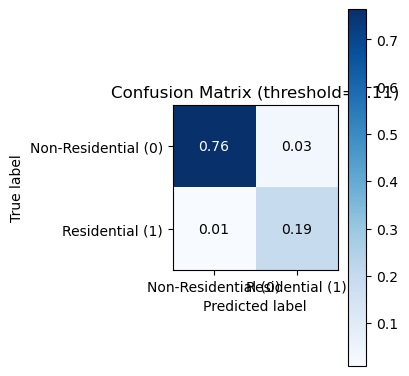

In [249]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_at_threshold(model, x_val, y_val, threshold=0.5, normalize=False):
    """
    Plot confusion matrix at a given decision threshold.
    If normalize=True, each cell is shown as a proportion of all samples.
    """
    y_pred_proba = model.predict(x_val).ravel()
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_val, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum()


    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ["Non-Residential (0)", "Residential (1)"]
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"Confusion Matrix (threshold={threshold:.2f})"
    )

    # Show values in each cell
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    return cm

cm = plot_confusion_matrix_at_threshold(model, x_test, y_test_binary, threshold=best_tau, normalize=True)

In [163]:

def plot_training_history(history, patience=5):
    """Plot training & validation loss and accuracy values"""
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    patience = 5
    plt.axvline(x=len(history.history['loss'])-patience, color='r', linestyle='--')
    plt.fill_betweenx(
        y=[min(min(history.history['loss']), min(history.history['val_loss'])), 
        max(max(history.history['loss']), max(history.history['val_loss']))],
        x1=len(history.history['loss'])-patience,
        x2=len(history.history['loss']),
        color='red',
        alpha=0.1
    )

    plt.legend(['Training', 'Validation'], loc='upper left')

    fig.add_subplot(122)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.axvline(x=len(history.history['accuracy'])-patience, color='r', linestyle='--')
    plt.fill_betweenx(
        y=[min(min(history.history['accuracy']), min(history.history['val_accuracy'])), 
        max(max(history.history['accuracy']), max(history.history['val_accuracy']))],
        x1=len(history.history['accuracy'])-patience,
        x2=len(history.history['accuracy']),
        color='red',
        alpha=0.1
    )

    plt.show()
    

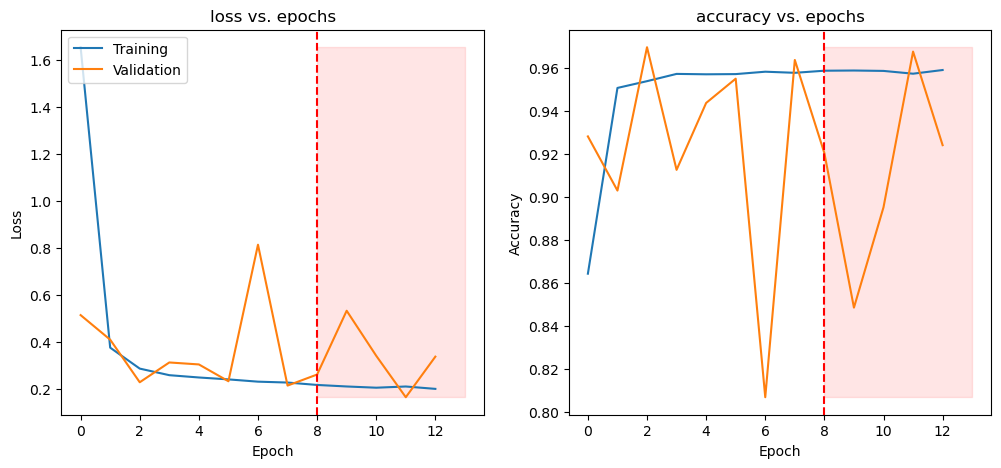

In [112]:
plot_training_history(history, patience=patience)

# Create new instance of model and load on both sets of weights

In [ ]:

import glob
import tensorflow as tf

def get_model_last_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    
    Here we instead load the full saved model from the latest .keras file.
    """
    ckpt_dir = "checkpoints_every_epoch"
    pattern = os.path.join(ckpt_dir, "checkpoint_*.keras")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError("No checkpoints found in 'checkpoints_every_epoch'.")

    # Because of checkpoint_{epoch:03d}.keras, max() gives the highest epoch number
    latest_ckpt = max(files)

    loaded_model = tf.keras.models.load_model(latest_ckpt)
    return loaded_model


def get_model_best_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier, load
    on the weights leading to the highest validation accuracy, and return this model.
    
    Here we load the full saved best model from 'checkpoints_best_only/checkpoint.keras'.
    """
    best_ckpt_path = os.path.join("checkpoints_best_only", "checkpoint.keras")
    if not os.path.exists(best_ckpt_path):
        raise FileNotFoundError("Best-checkpoint file not found at 'checkpoints_best_only/checkpoint.keras'.")

    loaded_model = tf.keras.models.load_model(best_ckpt_path)
    return loaded_model


In [91]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one wiht the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))

print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, x_test, y_test)


Model with last epoch weights:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6519 - loss: 0.9754
accuracy: 0.652

Model with best epoch weights:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6593 - loss: 1.0139
accuracy: 0.659


# Visualize feature maps

In [28]:
def plot_kernels(model, layer=0, n_cols=4, figsize=(8, 8)):
    """
    This function plots the kernels of the first convolutional layer of the model.
    """
    conv_layer = model.layers[layer]              # or model.get_layer(index=layer)
    weights, biases = conv_layer.get_weights()

    print("weights.shape:", weights.shape)
    print("biases.shape:", biases.shape)

    kernels = weights  # shape: (3, 3, 1, 16)

    n_filters = kernels.shape[-1]

    # Get the highest and lowest values for normalizing the color scale
    vmin, vmax = kernels.min(), kernels.max()
    print("vmin:", vmin, "vmax:", vmax)
    # get the maximum of abs(vmin), abs(vmax)
    max_abs = max(abs(vmin), abs(vmax))
    vmin, vmax = -max_abs, max_abs
    print("Normalized vmin:", vmin, "vmax:", vmax)

    # Choose a grid size (e.g., 4x4 for 16 filters)
    n_cols = n_cols
    n_rows = int(np.ceil(n_filters / n_cols))
    cmap = 'berlin_r'
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    plt.figure(figsize=figsize)

    for i in range(n_filters):
        # kernel for filter i, shape: (3, 3, 1)
        k = kernels[:, :, 0, i]   # squeeze channel dimension → (3,3)
        
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(k, interpolation='nearest', cmap=cmap, norm=norm)
        ax.set_title(f"Filter {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    print("Filter 0 weights:\n", kernels[:, :, 0, 0])
    print("\nFilter 1 weights:\n", kernels[:, :, 0, 1])
    print("\nFilter 5 weights:\n", kernels[:, :, 0, 5])

weights.shape: (3, 3, 3, 16)
biases.shape: (16,)
vmin: -0.28560716 vmax: 0.25334448
Normalized vmin: -0.28560716 vmax: 0.28560716


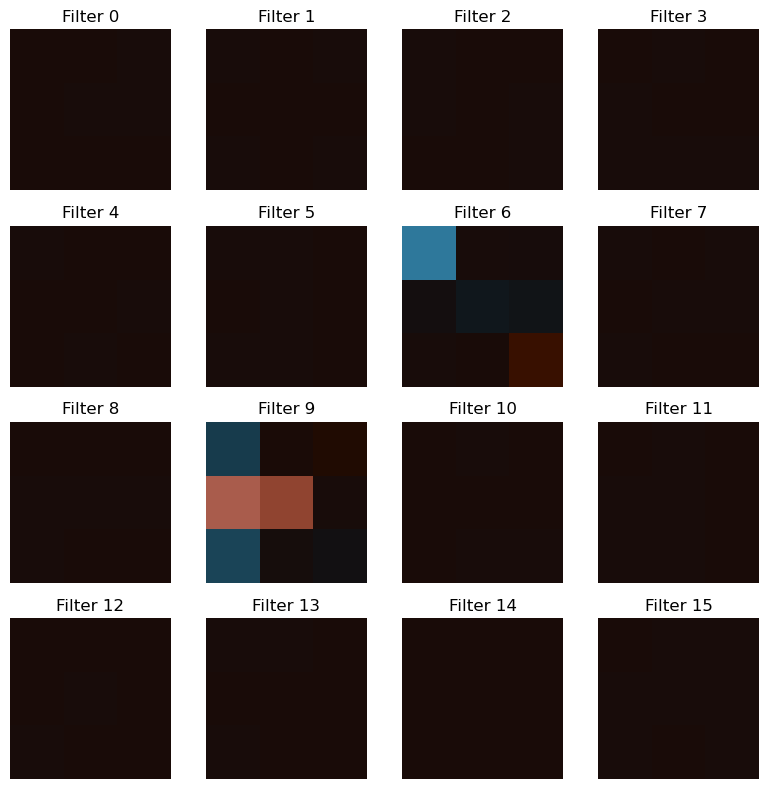

Filter 0 weights:
 [[-2.0530370e-04 -8.1660386e-05  1.2138624e-04]
 [-1.9663668e-04  6.6110850e-05  1.5191286e-04]
 [-1.8141148e-04 -5.8048754e-05 -4.7671219e-05]]

Filter 1 weights:
 [[ 7.9824458e-06 -5.8153681e-05  3.2478401e-06]
 [-5.6777801e-05 -5.3258867e-05 -7.3606561e-06]
 [ 3.2810956e-05 -4.1011790e-05  1.4026574e-05]]

Filter 5 weights:
 [[ 4.99024827e-05  4.07229163e-06 -6.84665138e-05]
 [-4.86826975e-05  3.20355866e-06 -2.87617822e-05]
 [ 2.32803704e-05  1.29274340e-05 -1.51211425e-05]]


In [114]:
plot_kernels(model)

In [115]:
layer_names = ['conv_1', 'conv_2', 'pool_1']
outputs = [model.get_layer(name).output for name in layer_names]

activation_model = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=outputs,
)


In [116]:
img = x_test[0]
img_batch = np.expand_dims(img, 0)

act_conv1, act_conv2, act_pool1 = activation_model.predict(img_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


In [117]:
print("conv_1 feature maps:", act_conv1.shape)   # (1, 64, 64, 16)
print("conv_2 feature maps:", act_conv2.shape)   # (1, 64, 64, 8)
print("pool_1 feature maps:", act_pool1.shape)   # (1, 8, 8, 8)

conv_1 feature maps: (1, 64, 64, 16)
conv_2 feature maps: (1, 64, 64, 8)
pool_1 feature maps: (1, 8, 8, 8)


## Example

Label: 0


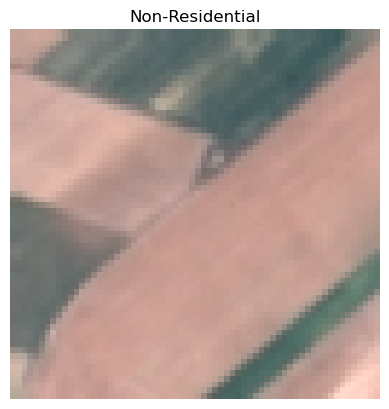

In [134]:
plot_one_image(x_test, y_test_binary, idx=0, decode_label=decode_label_binary)

In [136]:
def show_feature_maps(feature_maps, num_channels=6, title=""):
    # feature_maps: (1, H, W, C)
    fmap = feature_maps[0]  # (H, W, C)
    C = fmap.shape[-1]
    num_channels = min(num_channels, C)

    plt.figure(figsize=(12, 2))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(fmap[:, :, i], cmap="gray")
        plt.axis("off")
        plt.title(f"ch {i+1}")
    # move the suptitle down a bit
    plt.suptitle(title, y=1.05)
    plt.show()

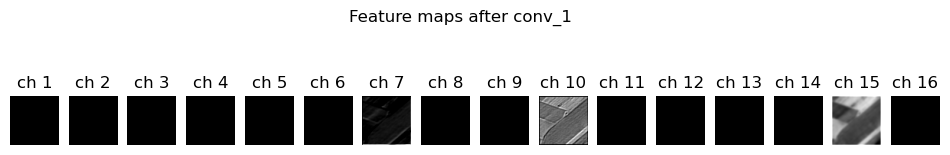

In [120]:
show_feature_maps(act_conv1, num_channels=16, title="Feature maps after conv_1")

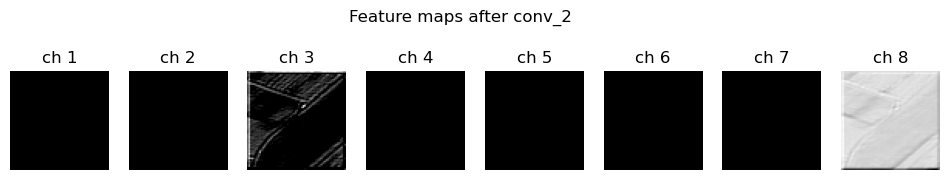

In [121]:
show_feature_maps(act_conv2, num_channels=8, title="Feature maps after conv_2")

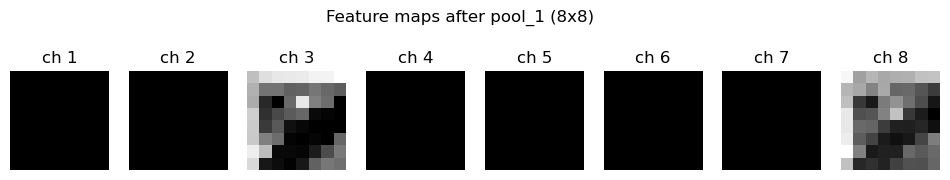

In [122]:
show_feature_maps(act_pool1, num_channels=8, title="Feature maps after pool_1 (8x8)")

In [123]:
def compute_saliency_map(model, image, class_index=None):
    """
    image: (H, W, 3), scaled to [0,1]
    Returns: saliency map (H, W) normalized to [0,1]
    """
    x = tf.convert_to_tensor(image[None, ...])  # (1, H, W, 3)

    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)          # (1, num_classes)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        score = preds[0, class_index]

    grads = tape.gradient(score, x)            # (1, H, W, 3)
    grads = tf.math.abs(grads)
    # max over color channels
    saliency = tf.reduce_max(grads, axis=-1)[0]  # (H, W)

    # normalize to [0,1]
    saliency_min = tf.reduce_min(saliency)
    saliency_max = tf.reduce_max(saliency)
    saliency_norm = (saliency - saliency_min) / (saliency_max - saliency_min + 1e-8)

    return saliency_norm.numpy(), int(class_index.numpy())

In [125]:
def plot_saliency_map(model, x_test, y_test, idx=None, decode_label=decode_label):
    """Plot saliency map for one test image."""
    if idx is None:
        idx = np.random.randint(0, x_test.shape[0])
    img = x_test[idx]          # shape (64, 64, 3)
    label = y_test[idx]
    saliency, pred_class = compute_saliency_map(model, img)

    print("True label:", decode_label(label), ", Predicted label:", decode_label(pred_class))
    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(decode_label(label))

    plt.subplot(1, 3, 2)
    plt.imshow(saliency, cmap="jet")
    plt.axis("off")
    plt.title("Saliency map")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(saliency, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay")
    plt.show()

True label: Non-Residential , Predicted label: Non-Residential


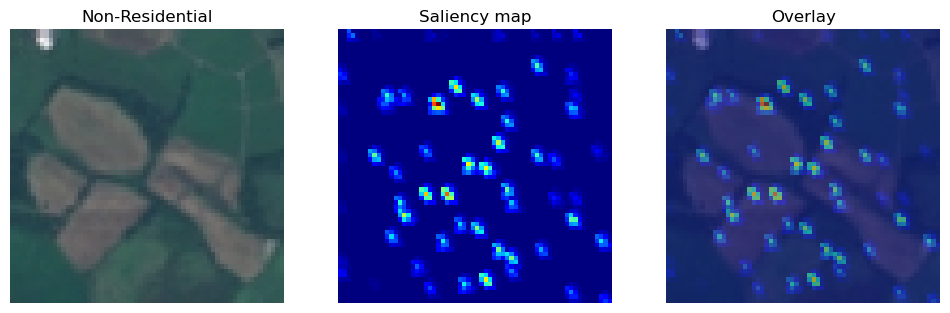

In [133]:
plot_saliency_map(model, x_test, y_test_binary, idx=4, decode_label=decode_label_binary)